# Monte Carlo Tree Search (MCTS)
This is an agent that plays with UCT-MCTS.  
Code is highly commented to be readable.

# Imports

In [1]:
# ConnectX environment was defined in v0.1.6
from kaggle_environments import evaluate, make, utils
import random
import math
import time

# RWM added
import numpy as np
import matplotlib.pyplot as plt

Loading environment lux_ai_2022 failed: No module named 'vec_noise'


# Create ConnectX Environment

In [2]:
env = make("connectx", debug=True)
configuration = env.configuration
print(configuration)

{'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'columns': 7, 'rows': 6, 'inarow': 4, 'agentTimeout': 60, 'timeout': 2}


# Functions

In [3]:
def MCTS_agent(observation, configuration):
    """
    Connect X agent based on MCTS.
    """
    import random
    import math
    import time
    global current_state  # so tree can be recycled

    init_time = time.time()
    EMPTY = 0
    T_max = configuration.timeout # time per move, left some overhead - RWM, old offset -0.34
    Cp_default = 1

    def play(board, column, mark, config):
        """ Plays a move. Taken from the Kaggle environment. """
        columns = config.columns
        rows = config.rows
        row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
        board[column + (row * columns)] = mark

    def is_win(board, column, mark, config):
        """ Checks for a win. Taken from the Kaggle environment. """
        columns = config.columns
        rows = config.rows

        # RWM edit
        inarow = config.inarow - 1

        # Connect3 to speed up testing?
        # inarow = 3 - 1

        row = min([r for r in range(rows) if board[column + (r * columns)] == mark])

        def count(offset_row, offset_column):
            for i in range(1, inarow + 1):
                r = row + offset_row * i
                c = column + offset_column * i
                if (
                        r < 0
                        or r >= rows
                        or c < 0
                        or c >= columns
                        or board[c + (r * columns)] != mark
                ):
                    return i - 1
            return inarow

        return (
                count(1, 0) >= inarow  # vertical.
                or (count(0, 1) + count(0, -1)) >= inarow  # horizontal.
                or (count(-1, -1) + count(1, 1)) >= inarow  # top left diagonal.
                or (count(-1, 1) + count(1, -1)) >= inarow  # top right diagonal.
        )

    def is_tie(board):
        """ Checks if a tie occured. """
        return not(any(mark == EMPTY for mark in board))

    def check_finish_and_score(board, column, mark, config):
        """ Returns a tuple where the first argument states whether game is finished and second argument returns score if game has finished. """
        if is_win(board, column, mark, config):
            return (True, 1)
        if is_tie(board):
            # RWM - default tie score = 0.5 - what if we change this? ie, punish draws to promote aggressive play?
            return (True, 0.1)
        else:
            return (False, None)

    def uct_score(node_total_score, node_total_visits, parent_total_visits, Cp=Cp_default):
        """ UCB1 calculation. """
        if node_total_visits == 0:
            return math.inf
        return node_total_score / node_total_visits + Cp * math.sqrt(
            2 * math.log(parent_total_visits) / node_total_visits)

    def opponent_mark(mark):
        """ The mark indicates which player is active - player 1 or player 2. """
        return 3 - mark

    def opponent_score(score):
        """ To backpropagate scores on the tree. """
        return 1 - score

    def random_action(board, config):
        """ Returns a random legal action (from the open columns). """
        return random.choice([c for c in range(config.columns) if board[c] == EMPTY])

    def default_policy_simulation(board, mark, config):
        """
        Run a random play simulation. Starting state is assumed to be a non-terminal state.
        Returns score of the game for the player with the given mark.
        """
        original_mark = mark
        board = board.copy()
        column = random_action(board, config)
        play(board, column, mark, config)
        is_finish, score = check_finish_and_score(board, column, mark, config)
        while not is_finish:
            mark = opponent_mark(mark)
            column = random_action(board, config)
            play(board, column, mark, config)
            is_finish, score = check_finish_and_score(board, column, mark, config)
        if mark == original_mark:
            return score
        return opponent_score(score)
    
    def find_action_taken_by_opponent(new_board, old_board, config):
        """ Given a new board state and a previous one, finds which move was taken. Used for recycling tree between moves. """
        for i, piece in enumerate(new_board):
            if piece != old_board[i]:
                return i % config.columns
        return -1  # shouldn't get here

    class State():
        """ 
        A class that represents nodes in the game tree.
        
        """
        def __init__(self, board, mark, config, parent=None, is_terminal=False, terminal_score=None, action_taken=None):
            self.board = board.copy()
            self.mark = mark
            self.config = config
            self.children = []
            self.parent = parent
            self.node_total_score = 0
            self.node_total_visits = 0
            self.available_moves = [c for c in range(config.columns) if board[c] == EMPTY]
            self.expandable_moves = self.available_moves.copy()
            self.is_terminal = is_terminal
            self.terminal_score = terminal_score
            self.action_taken = action_taken

        def is_expandable(self):
            """ Checks if the node has unexplored children. """
            return (not self.is_terminal) and (len(self.expandable_moves) > 0)

        def expand_and_simulate_child(self):
            """ Expands a random move from the legal unexplored moves, and runs a simulation of it 
            (Expansion + Simulation + Backpropagation stages in the MCTS algorithm description). """
            column = random.choice(self.expandable_moves)
            child_board = self.board.copy()
            play(child_board, column, self.mark, self.config)
            is_terminal, terminal_score = check_finish_and_score(child_board, column, self.mark, self.config)
            self.children.append(State(child_board, opponent_mark(self.mark),
                                       self.config, parent=self,
                                       is_terminal=is_terminal,
                                       terminal_score=terminal_score,
                                       action_taken=column
                                       ))
            simulation_score = self.children[-1].simulate()
            self.children[-1].backpropagate(simulation_score)
            self.expandable_moves.remove(column)

        def choose_strongest_child(self, Cp):
            """
            Chooses child that maximizes UCB1 score (Selection stage in the MCTS algorithm description).
            """
            children_scores = [uct_score(child.node_total_score,
                                         child.node_total_visits,
                                         self.node_total_visits,
                                         Cp) for child in self.children]
            max_score = max(children_scores)
            best_child_index = children_scores.index(max_score)
            return self.children[best_child_index]
            
        def choose_play_child(self):
            """ Choose child with maximum total score."""
            children_scores = [child.node_total_score for child in self.children]
            max_score = max(children_scores)
            best_child_index = children_scores.index(max_score)
            return self.children[best_child_index]

        def tree_single_run(self):
            """
            A single iteration of the 4 stages of the MCTS algorithm.
            """
            if self.is_terminal:
                self.backpropagate(self.terminal_score)
                return
            if self.is_expandable():
                self.expand_and_simulate_child()
                return
            self.choose_strongest_child(Cp_default).tree_single_run()

        def simulate(self):
            """
            Runs a simulation from the current state. 
            This method is used to simulate a game after move of current player, so if a terminal state was reached,
            the score would belong to the current player who made the move.
            But otherwise the score received from the simulation run is the opponent's score and thus needs to be flipped with the function opponent_score().            
            """
            if self.is_terminal:
                return self.terminal_score
            return opponent_score(default_policy_simulation(self.board, self.mark, self.config))

        def backpropagate(self, simulation_score):
            """
            Backpropagates score and visit count to parents.
            """
            self.node_total_score += simulation_score
            self.node_total_visits += 1
            if self.parent is not None:
                self.parent.backpropagate(opponent_score(simulation_score))
                
        def choose_child_via_action(self, action):
            """ Choose child given the action taken from the state. Used for recycling of tree. """
            for child in self.children:
                if child.action_taken == action:
                    return child
            return None

    board = observation.board
    mark = observation.mark
    
    # If current_state already exists, recycle it based on action taken by opponent
    try:  
        current_state = current_state.choose_child_via_action(
            find_action_taken_by_opponent(board, current_state.board, configuration))
        current_state.parent = None  # make current_state the root node, dereference parents and siblings
        
    except:  # new game or other error in recycling attempt due to Kaggle mechanism
        current_state = State(board, mark,  # This state is considered after the opponent's move
                              configuration, parent=None, is_terminal=False, terminal_score=None, action_taken=None)
   
    # Run MCTS iterations until time limit is reached.
    while time.time() - init_time <= T_max:
        current_state.tree_single_run()
        
    current_state = current_state.choose_play_child()
    return current_state.action_taken

# Check agent validity

In [4]:
env.reset()
try:
    del current_state
except:
    pass

env.run([MCTS_agent, MCTS_agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!


# Evaluate your agent

In [5]:
# RWM edit - kept dividing by zero...
# -1 = always loss, +1 = always win, ~0 = evens

def mean_reward(rewards):
    avg = sum(r[0] for r in rewards) / len(rewards)
    num_losses = sum(-r[0] for r in rewards if r[0] == -1)

    print_string = f"Score = {avg}, N = {len(rewards)}, losses = {num_losses}"

    return print_string, avg

# Run multiple episodes to estimate its performance.
iterations = 1

# RWM tests
print("BENCHMARK - Negamax vs Random:", mean_reward(evaluate("connectx", ["negamax", "random"], num_episodes = iterations))[0])
print("TEST - Random vs Random:", mean_reward(evaluate("connectx", ["random", "random"], num_episodes = iterations))[0])

# RWM edit, old = 20 20 5 5

print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [MCTS_agent, "random"], num_episodes = iterations))[0])
# print("Random Agent vs My Agent:", mean_reward(evaluate("connectx", ["random", MCTS_agent], num_episodes = iterations))[0])
# print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [MCTS_agent, "negamax"], num_episodes = iterations))[0])
# print("Negamax Agent vs My Agent:", mean_reward(evaluate("connectx", ["negamax", MCTS_agent], num_episodes = iterations))[0])

BENCHMARK - Negamax vs Random: Score = 1.0, N = 1, losses = 0
TEST - Random vs Random: Score = 1.0, N = 1, losses = 0
My Agent vs Random Agent: Score = 1.0, N = 1, losses = 0


In [6]:
# time to 50:50?
rel_iterations = 10
print("TEST - Random vs Random:", mean_reward(evaluate("connectx", ["random", "random"], num_episodes = 5 * rel_iterations))[0])

TEST - Random vs Random: Score = 0.08, N = 50, losses = 23


In [7]:
# rel_iterations = 100
# print("TEST - Random vs Random:", mean_reward(evaluate("connectx", ["random", "random"], num_episodes = 5 * rel_iterations))[0])

In [8]:
# # how long before NEGAMAX loses to RANDOM?

# iterations = (2, 5, 10, 25, 50, 100) // 10 + 2
# index = 1   # for plotting
# MCTS_first = []
# MCTS_second = []
# time_first = []
# time_second = []

# for i in iterations:
#     start1 = time.time()
#     reward_first = mean_reward(evaluate("connectx", ["negamax", "random"], num_episodes = i))[1]
#     time_first.append(time.time() - start1)

#     start2 = time.time()
#     reward_second = mean_reward(evaluate("connectx", ["random", "negamax"], num_episodes = i))[1]
#     time_second.append(time.time() - start2)

#     print("My Agent vs Negamax Agent:", reward_first)
#     print("Negamax Agent vs My Agent:", reward_second)
#     print("*"*58)

#     MCTS_first.append(reward_first)
#     MCTS_second.append(reward_second)

#     fig, ax = plt.subplots(2, 2, figsize=(9, 6))

#     ax[0][0].plot(iterations[:index], MCTS_first, label="Negamax 1st", color = 'cyan', linewidth=1.5)
#     ax[0][1].plot(iterations[:index], MCTS_second, label="Negamax 2nd", color = 'orange', linewidth=1.5)

#     ax[1][0].plot(iterations[:index], time_first, color = 'cyan', linewidth=1.5)
#     ax[1][1].plot(iterations[:index], time_second, color = 'orange', linewidth=1.5)


#     (a.set_xlabel("#iterations") for a in ax)
#     ax[0][0].set_ylabel("Score (+1 = perfect)")
#     ax[1][0].set_ylabel("Comp time on Mac (seconds)")

#     lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#     lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#     fig.legend(lines, labels, loc='upper right')

#     plt.show()
    
#     print("*"*58)

#     index += 1

My Agent vs Negamax Agent: 0.96
Negamax Agent vs My Agent: -1.0
N = 25
Avg +/- 1SD comp time per episode 4684.397513359785 +/- 4.570941366076774 seconds
Time elapsed = 34.953302296002704 minutes
**********************************************************


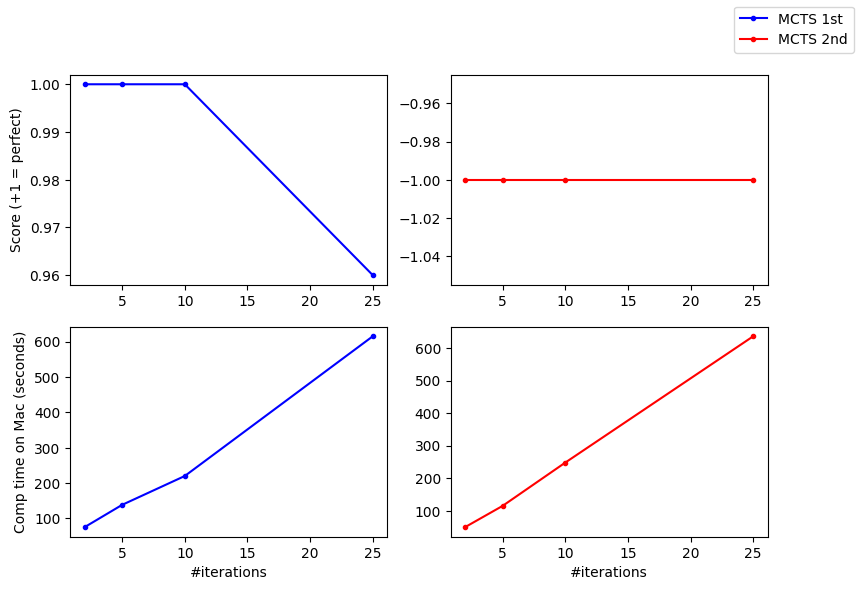

**********************************************************


In [9]:
# how long before MCTS loses to NEGAMAX?
from IPython.display import clear_output

iterations = [2, 5, 10, 25, 50, 100]
index = 1   # for plotting
MCTS_first = []
MCTS_second = []
time_first = []
time_second = []

start_global = time.time()

for i in iterations:
    start1 = time.time()
    reward_first = mean_reward(evaluate("connectx", [MCTS_agent, "negamax"], num_episodes = i))[1]
    time_first.append(time.time() - start1)

    start2 = time.time()
    reward_second = mean_reward(evaluate("connectx", ["negamax", MCTS_agent], num_episodes = i))[1]
    time_second.append(time.time() - start2)

    clear_output(wait=True)
    print("My Agent vs Negamax Agent:", reward_first)
    print("Negamax Agent vs My Agent:", reward_second)
    print("N =", i)
    print("Avg +/- 1SD comp time per episode", 
            np.mean( ( (np.array( time_first ) + np.array( time_second ) ) / 2 * np.array(iterations[:index]))),
            "+/-",
            np.std( np.array(time_first + time_second) / np.array( (iterations[:index] + iterations[:index]).sort() ),
            "seconds")
    
    print("Time elapsed =", (time.time() - start_global) / 60, "minutes")
    print("*"*58)

    MCTS_first.append(reward_first)
    MCTS_second.append(reward_second)

    fig, ax = plt.subplots(2, 2, figsize=(9, 6))

    ax[0][0].plot(iterations[:index], MCTS_first, 'o-', label="MCTS 1st", color = 'blue', linewidth=1.5, markersize=3)
    ax[0][1].plot(iterations[:index], MCTS_second, 'o-', label="MCTS 2nd", color = 'red', linewidth=1.5, markersize=3)

    ax[1][0].plot(iterations[:index], time_first, 'o-', color = 'blue', linewidth=1.5, markersize=3)
    ax[1][1].plot(iterations[:index], time_second, 'o-', color = 'red', linewidth=1.5, markersize=3)

    ax[1][0].set_xlabel("#iterations")
    ax[1][1].set_xlabel("#iterations")

    ax[0][0].set_ylabel("Score (+1 = perfect)")
    ax[1][0].set_ylabel("Comp time on Mac (seconds)")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc='upper right')

    plt.show()
    
    print("*"*58)

    index += 1